In [14]:
import numpy as np
import matplotlib.pyplot as plt

# @title Plotting functions

def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()


In [15]:
#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

In [16]:
type(spike_times)
spike_times.shape

idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

idx = 321
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

# different sizes of 1D arrays in an array, each array corresponds to each of the 734 neurons and each element corresponds to the spike time

n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

<class 'numpy.ndarray'>
(826,)
<class 'numpy.ndarray'>
(9723,)
Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


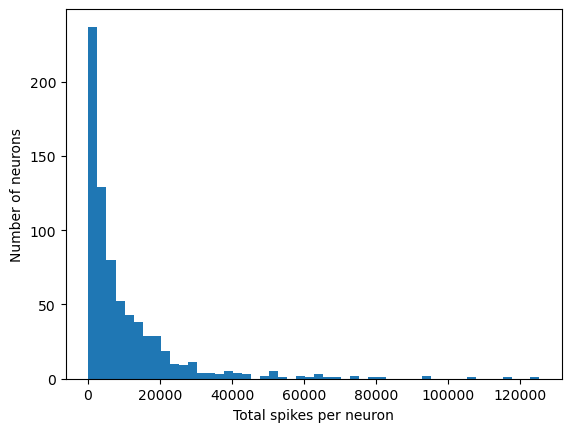

In [17]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");

In [18]:
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f"{frac_below_mean:2.1%} of neurons are below the mean")

68.0% of neurons are below the mean


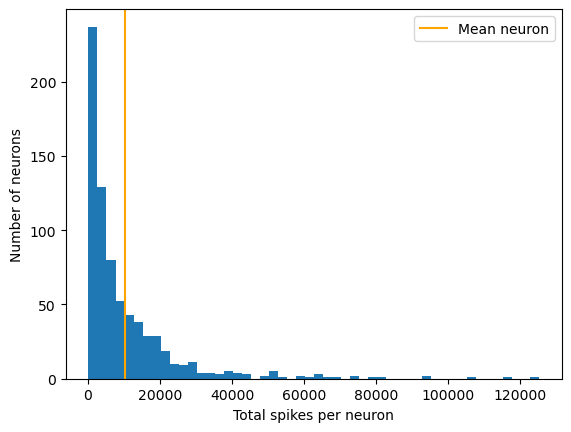

In [19]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();

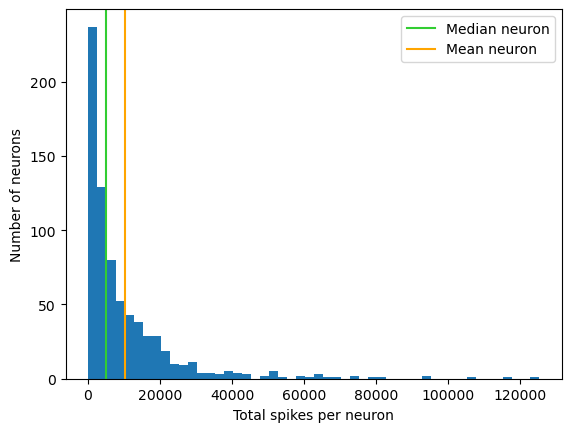

In [20]:
# Compute median spike count
median_spike_count = np.median(total_spikes_per_neuron)  # Hint: Try the function np.median

# Visualize median, mean, and histogram
plt.hist((total_spikes_per_neuron), bins=50, histtype="stepfilled")
plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.legend()

In [21]:
# @markdown Execute this cell for helper function `restrict_spike_times`
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")


spike_times_flat = np.concatenate(spike_times)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = t_interval[1] - t_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.33% of the total spikes are in the interval
0.37% of the total time is in the interval


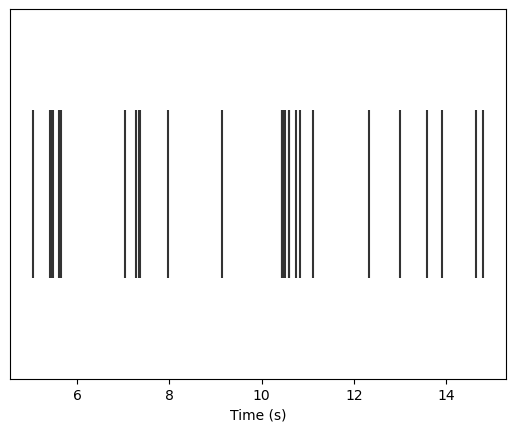

In [22]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

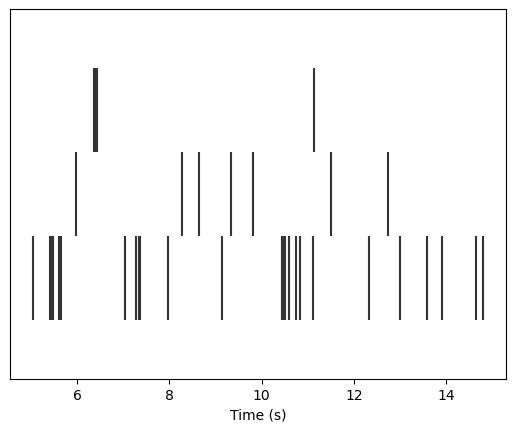

In [23]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

# This is called a raster plot.

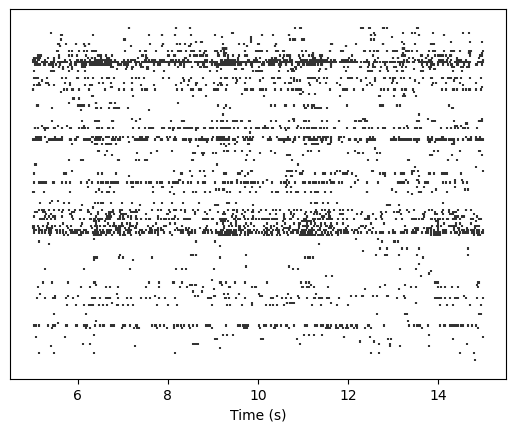

In [24]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

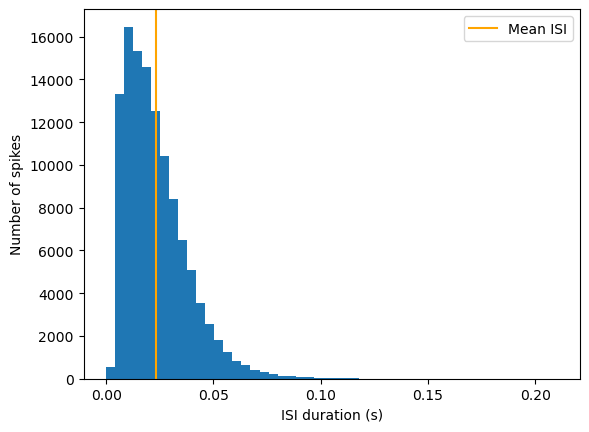

In [25]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Compute a vector of ISIs for a single neuron given spike times.

  Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.

  Returns:
    isis (1D array): Duration of time between each spike from one neuron.
  """

  # Extract the spike times for the specified neuron
  single_neuron_spikes = spike_times[neuron_idx]

  # Compute the ISIs for this set of spikes
  # Hint: the function np.diff computes discrete differences along an array
  isis = np.diff(single_neuron_spikes)

  return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
plot_isis(single_neuron_isis)

We are gonna use a Linear IF Neuron, which is a point neuron. That is to say, a neuron's membrane potential is represented as a single number. Assuming the input current over a timestep is due to equal contributions from a non-negative integer number of input spikes arriving in that timestep, we can use a Poisson distribution.

In [28]:
# @title Plotting Functions

def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')

  # ISI distribution
  if len(spike_times)>1:
    isi = np.diff(spike_times)
    n_bins = np.arange(isi.min(), isi.max() + 2) - .5
    counts, bins = np.histogram(isi, n_bins)
    vlines = []
    if len(isi) > 0:
      vlines = [np.mean(isi)]
    xmax = max(20, int(bins[-1])+5)
    histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
      'xlabel': 'Inter-spike interval',
      'ylabel': 'Number of intervals',
      'xlim': [0, xmax]
    })
  else:
    ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
  plt.show()

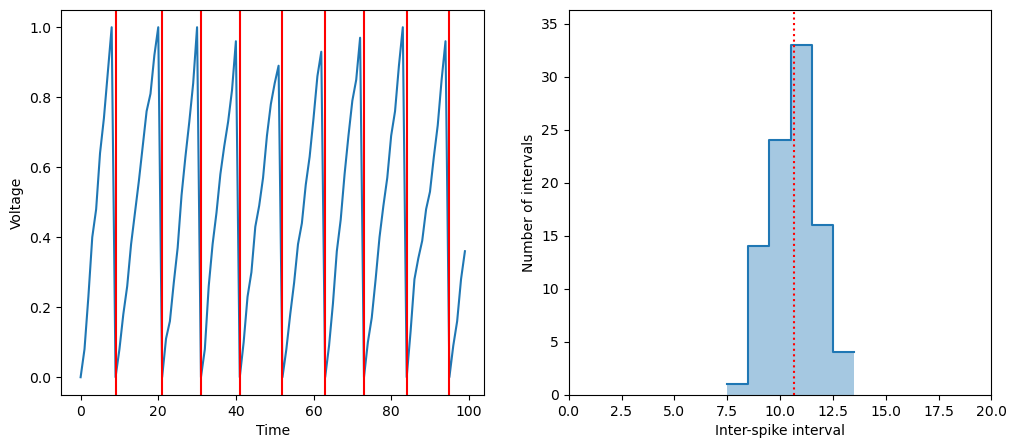

In [34]:
from scipy import stats

def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes

  """
  # Precompute Poisson samples for speed
  exc = stats.poisson(rate).rvs(n_steps) # rate is the parameter alpha, .rvs(n_steps) generates n_steps number of random samples

  # Initialize voltage and spike storage
  v = np.zeros(n_steps)
  spike_times = []

  # Loop over steps
  for i in range(1, n_steps):

    # Update v
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv

    # If spike happens, reset voltage and record
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron()

# Visualize
plot_neuron_stats(v, spike_times)

Now we use Leaky IF Neuron

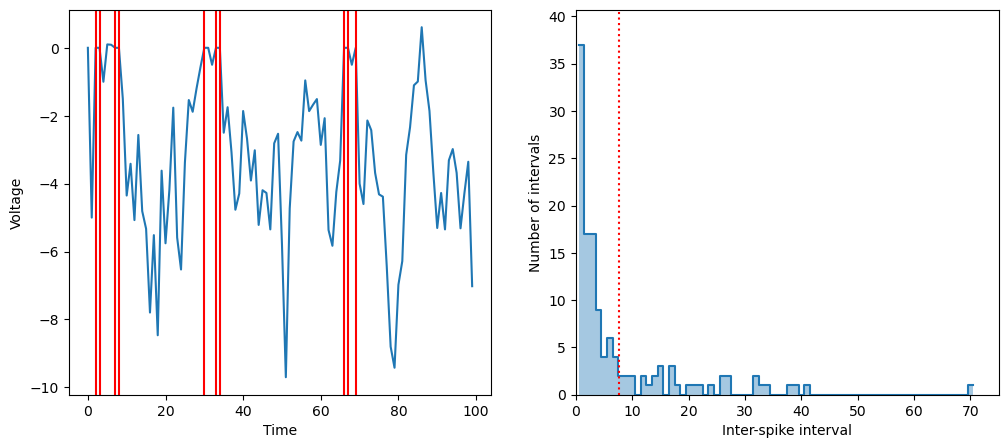

In [37]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """

  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []

  for i in range(1, n_steps):

    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron_inh()

# Visualize
plot_neuron_stats(v, spike_times)

The fact that the output ISI distribution looks like exponential function implies that the input ISI distribution would also look the same. So in the brain, the input must look just like the outputs.